In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.pyplot import scatter, figure
from scipy import stats
from numpy.ma.core import outer
from sys import stderr


In [3]:
start = -7
end = 7
n = 300
batch_size = 16

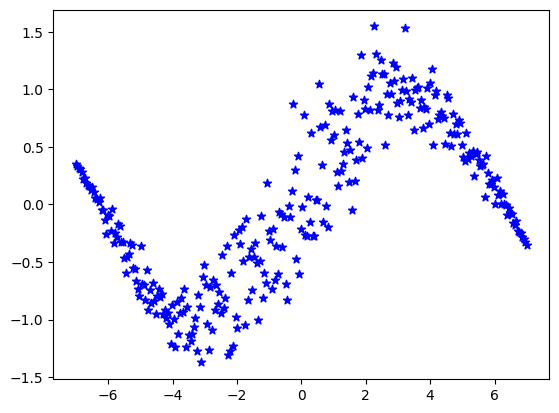

In [4]:
def sample_dataset(start, end, n):
    np.random.seed(0)
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]

    sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs(random_state=0)
    return x, y

x_train, y_train = sample_dataset(start, end, n)
scatter(x_train, y_train, c="blue", marker="*")

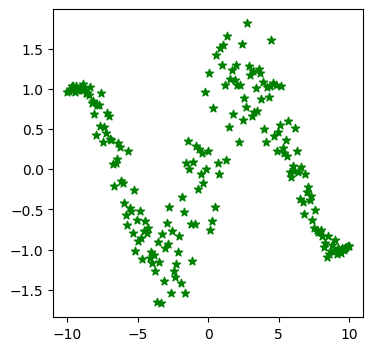

In [5]:
figure(figsize=(4, 4))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(-10, 10, 200)
scatter(x_test, y_test, c="green", marker="*")

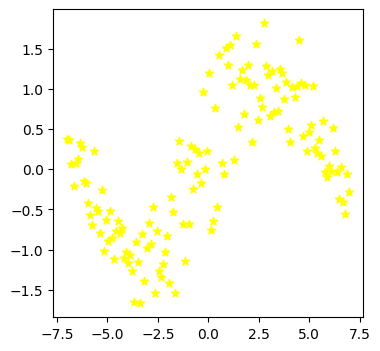

In [6]:
#Plotting In Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask =  (x_test >= -7) &  (x_test <= 7) # Select the ranges -10 to -7 and 7 to 10
x_test_idd = x_test[mask]
y_test_idd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_idd, y_test_idd, c="yellow", marker="*")

plt.show()


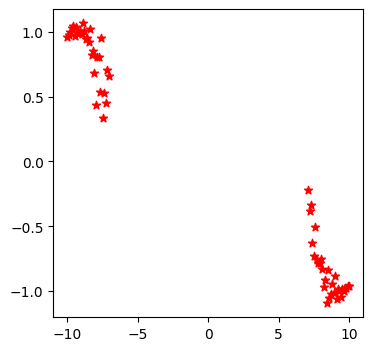

In [7]:
#Plotting Out of Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask = (x_test >= -10) & (x_test < -7) | (x_test > 7) & (x_test <= 10) # Select the ranges -10 to -7 and 7 to 10
x_test_oodd = x_test[mask]
y_test_oodd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_oodd, y_test_oodd, c="red", marker="*")

plt.show()


In [8]:

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#Test for OODD (Out of Data Distribution)
tensor_x_test_oodd = torch.Tensor(x_test_oodd).unsqueeze(1)
tensor_y_test_oodd = torch.Tensor(y_test_oodd).unsqueeze(1)
test_dataset_oodd = TensorDataset(tensor_x_test_oodd, tensor_y_test_oodd)
test_loader_oodd = DataLoader(test_dataset_oodd, batch_size=batch_size, shuffle=True)

#Test for IDD (In Data Distribution)
tensor_x_test_idd = torch.Tensor(x_test_idd).unsqueeze(1)
tensor_y_test_idd = torch.Tensor(y_test_idd).unsqueeze(1)
test_dataset_idd = TensorDataset(tensor_x_test_idd, tensor_y_test_idd)
test_loader_idd = DataLoader(test_dataset_idd, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
modelSamples = 50

In [10]:
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F

class DeepONet(nn.Module):
    def __init__(self):
        super(DeepONet, self).__init__()
        self.hidden_size = 35

        # We only have 1 input feature
        self.b1 = nn.Linear(1, self.hidden_size)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size)

        self.t1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.t2 = nn.Linear(self.hidden_size, self.hidden_size)

        self.mu = nn.Linear(self.hidden_size, 1)
        self.var = nn.Linear(self.hidden_size, 1)

    def forward(self, x):

        h = torch.tanh(self.b1(x))
        h = torch.tanh(self.b2(h))

        input_noise = torch.normal(0, 1, size=(x.shape[0], self.hidden_size))

        t           = torch.tanh(self.t1(input_noise))
        t           = torch.tanh(self.t2(t))
        prod        = torch.multiply(t,h)

        mu = self.mu(prod)
        # Exponential activation to enforce positive var
        # Arash: this might be a significant difference:
        var = torch.exp(self.var(prod))
        return mu, var

sns.set(rc={'figure.figsize':(4, 4)})
def make_plot_dpo(model):
    # Get predictions
    mus = []
    vars = []
    for m in range(modelSamples):
        mu, var = model(tensor_x_test)
        mus.append(mu)
        vars.append(var)
    # For epistemic uncertainty we calculate the std on the mus!
    # Arash: note how vars is no longer used in evaluation
    means = torch.stack(mus).mean(axis=0).detach().numpy()
    # stds = torch.stack(vars).mean(axis=0).detach().numpy()**(1/2)
    stds = torch.stack(mus).std(axis=0).detach().numpy()**(1/2) + \
                torch.stack(vars).mean(axis=0).detach().numpy()**(1/2)
    mu = means
    sigma = stds
    # mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)
    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []
    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()
    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")
    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)
    # Plot test data on top
    scatter(x_test, y_test, c="green", marker="*", alpha=0.5)
    plt.savefig("dpo.png", dpi=300, bbox_inches='tight')  # Add this line
    plt.show()



In [11]:
#Plot function for Out of Distribution Data
def make_plot_dpo_oodd(model):
    # Get predictions
    mus = []
    vars = []

    for m in range(modelSamples):
        mu, var = model(tensor_x_test_oodd)
        mus.append(mu)
        vars.append(var)
    # For epistemic uncertainty we calculate the std on the mus!
    # Arash: note how vars is no longer used in evaluation
    means = torch.stack(mus).mean(axis=0).detach().numpy()

    # stds = torch.stack(vars).mean(axis=0).detach().numpy()**(1/2)
    stds = torch.stack(mus).std(axis=0).detach().numpy()**(1/2) + \
                torch.stack(vars).mean(axis=0).detach().numpy()**(1/2)

    mu = means
    sigma = stds
    # mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)

    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []

    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test_oodd.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test_oodd, y_test_oodd, c="red", marker="*", alpha=0.5)
    plt.show()

In [12]:
#Plot function for In Distribution Data
def make_plot_dpo_idd(model):
    # Get predictions
    mus = []
    vars = []

    for m in range(modelSamples):
        mu, var = model(tensor_x_test_idd)
        mus.append(mu)
        vars.append(var)
    # For epistemic uncertainty we calculate the std on the mus!
    # Arash: note how vars is no longer used in evaluation
    means = torch.stack(mus).mean(axis=0).detach().numpy()

    # stds = torch.stack(vars).mean(axis=0).detach().numpy()**(1/2)
    stds = torch.stack(mus).std(axis=0).detach().numpy()**(1/2) + \
                torch.stack(vars).mean(axis=0).detach().numpy()**(1/2)

    mu = means
    sigma = stds
    # mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)

    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []

    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test_idd.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test_idd, y_test_idd, c="yellow", marker="*", alpha=0.5)
    plt.show()

In [13]:
net = DeepONet()
print(net)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

DeepONet(
  (b1): Linear(in_features=1, out_features=35, bias=True)
  (b2): Linear(in_features=35, out_features=35, bias=True)
  (t1): Linear(in_features=35, out_features=35, bias=True)
  (t2): Linear(in_features=35, out_features=35, bias=True)
  (mu): Linear(in_features=35, out_features=1, bias=True)
  (var): Linear(in_features=35, out_features=1, bias=True)
)
Params: 3922


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
net.to(device);

In [15]:
def MLE_dopnn():
  net= DeepONet()
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  net.train()
  net.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
        criterionmse_train = nn.MSELoss()
        mse_train = criterionmse_train(mu, y)
    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
             criterionmse_test = nn.MSELoss()
             all_mse_test.append(criterionmse_test(mu,y).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        test_mse=sum(all_mse_test)/len(all_mse_test)
  make_plot_dpo(net)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  return loss, test_loss, mse_train, test_mse


In [16]:
def MLE_dopnn_idd():
  net= DeepONet()
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  net.train()
  net.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
        criterionmse_train = nn.MSELoss()
        mse_train = criterionmse_train(mu, y)
    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader_idd:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
             criterionmse_test = nn.MSELoss()
             all_mse_test.append(criterionmse_test(mu,y).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        test_mse=sum(all_mse_test)/len(all_mse_test)
  make_plot_dpo_idd(net)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  return loss, test_loss, mse_train, test_mse


In [17]:
def MLE_dopnn_oodd():
  net= DeepONet()
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  net.train()
  net.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
        criterionmse_train = nn.MSELoss()
        mse_train = criterionmse_train(mu, y)
    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader_oodd:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
             criterionmse_test = nn.MSELoss()
             all_mse_test.append(criterionmse_test(mu,y).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        test_mse=sum(all_mse_test)/len(all_mse_test)
  make_plot_dpo_oodd(net)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  return loss, test_loss, mse_train, test_mse


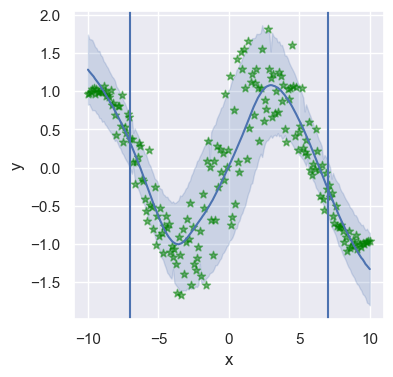

Epoch 149 | batch train loss: -0.8350429534912109 | test loss: 0.2820478319548644
Epoch 149 |batch train mse:0.0659097358584404| test mse:0.14187627400343233


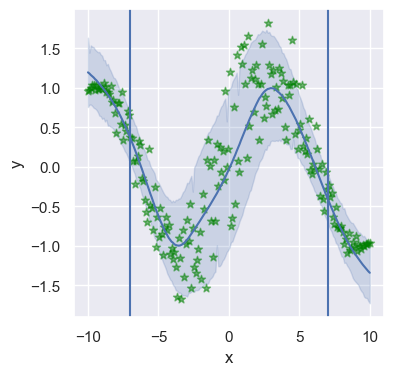

Epoch 149 | batch train loss: -1.3463460206985474 | test loss: -0.04250792815135075
Epoch 149 |batch train mse:0.06754567474126816| test mse:0.13592416134018165


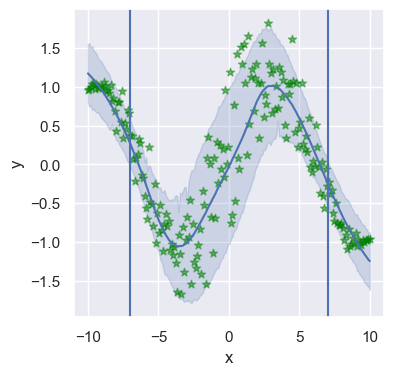

Epoch 149 | batch train loss: -0.6772331595420837 | test loss: 0.09876815401590787
Epoch 149 |batch train mse:0.14528705179691315| test mse:0.1385218879351249


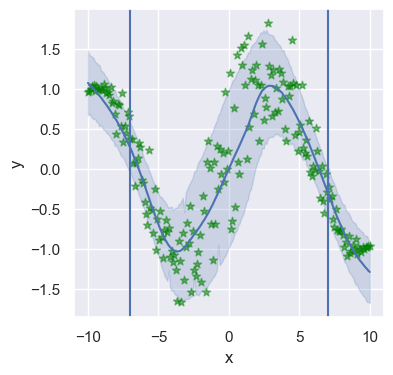

Epoch 149 | batch train loss: -1.1232107877731323 | test loss: 0.1985561354802205
Epoch 149 |batch train mse:0.0683240070939064| test mse:0.14944797811599878


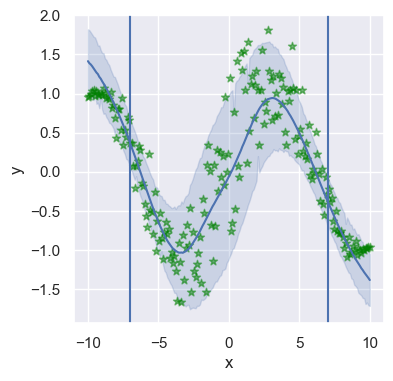

Epoch 149 | batch train loss: -1.208980679512024 | test loss: 0.35264796362473416
Epoch 149 |batch train mse:0.027374453842639923| test mse:0.14647420667684996


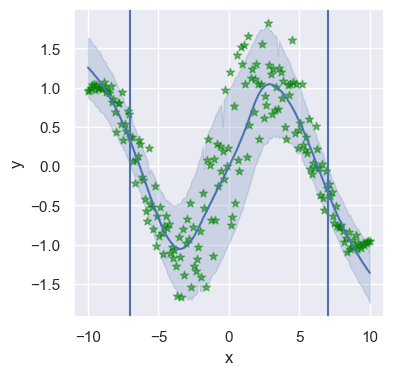

Epoch 149 | batch train loss: -1.3571935892105103 | test loss: 0.32243478068938625
Epoch 149 |batch train mse:0.03816056251525879| test mse:0.1454516494503388


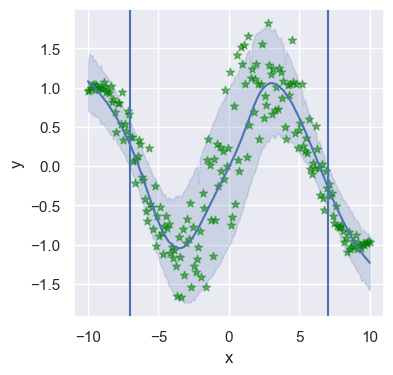

Epoch 149 | batch train loss: -0.9795716404914856 | test loss: 0.11928679736760947
Epoch 149 |batch train mse:0.058824557811021805| test mse:0.14427228558522004


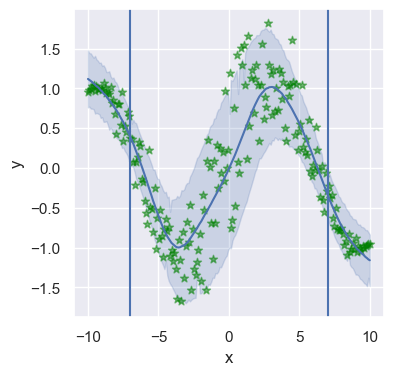

Epoch 149 | batch train loss: -0.9273295402526855 | test loss: 0.060216729457561784
Epoch 149 |batch train mse:0.04583879932761192| test mse:0.14731106964441446


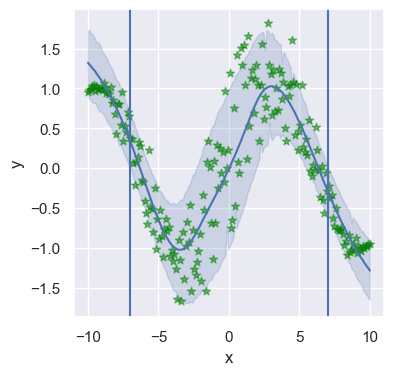

Epoch 149 | batch train loss: -0.8474056124687195 | test loss: 0.42413145303726196
Epoch 149 |batch train mse:0.06927645951509476| test mse:0.1468747894351299


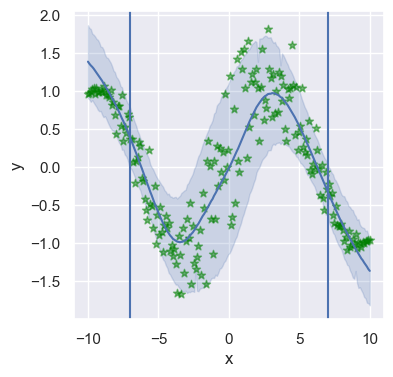

Epoch 149 | batch train loss: -1.5357469320297241 | test loss: 0.2431534964304704
Epoch 149 |batch train mse:0.029285138472914696| test mse:0.14315930696634147


In [18]:
train_losses=[]
test_losses=[]
errors_train=[]
errors_test=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = MLE_dopnn()
  train_losses.append(tr_loss)
  test_losses.append(test_loss)
  errors_train.append(mse_tr)
  errors_test.append(mse_test)

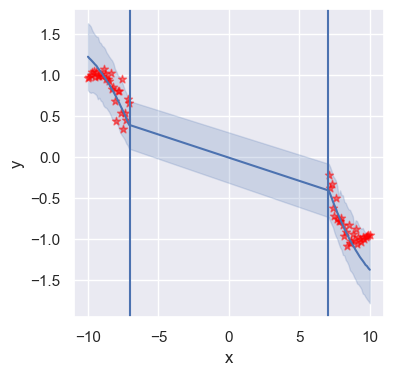

Epoch 149 | batch train loss: -1.2475665807724 | test loss: -1.0019857361912727
Epoch 149 |batch train mse:0.06661008298397064| test mse:0.026011986890807748


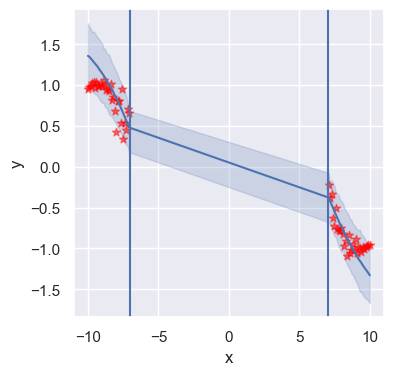

Epoch 149 | batch train loss: -1.043476939201355 | test loss: -0.4491381198167801
Epoch 149 |batch train mse:0.05386510118842125| test mse:0.037068940699100494


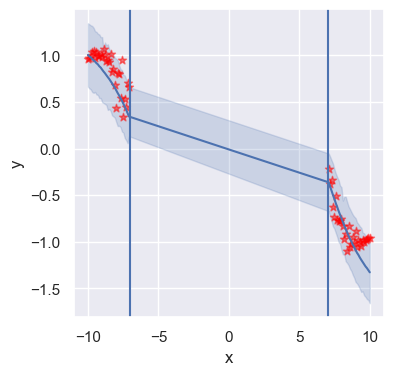

Epoch 149 | batch train loss: -1.140102505683899 | test loss: -1.1097213551402092
Epoch 149 |batch train mse:0.08511478453874588| test mse:0.023857273859903216


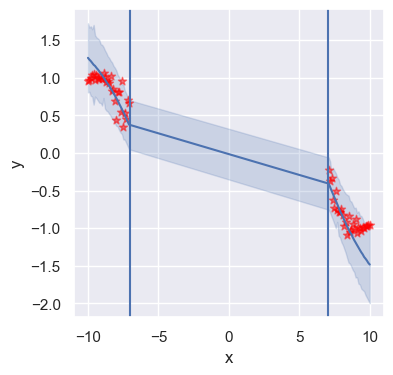

Epoch 149 | batch train loss: -0.8658480644226074 | test loss: -0.5770586766302586
Epoch 149 |batch train mse:0.06063167378306389| test mse:0.039518944919109344


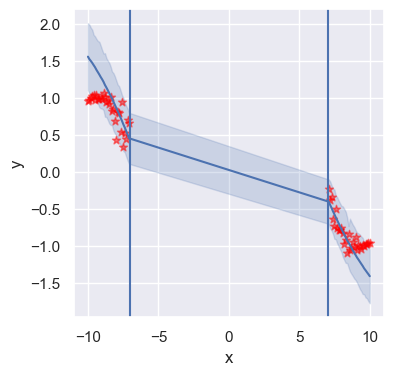

Epoch 149 | batch train loss: -0.9318282008171082 | test loss: 0.49547140300273895
Epoch 149 |batch train mse:0.11427823454141617| test mse:0.05600364692509174


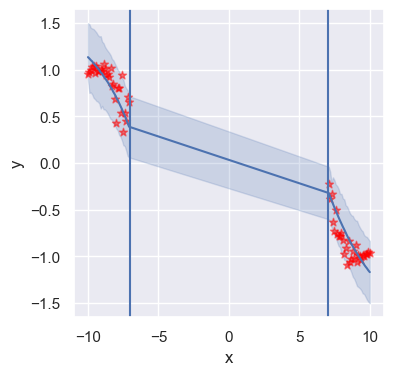

Epoch 149 | batch train loss: -1.333253026008606 | test loss: -0.9013665616512299
Epoch 149 |batch train mse:0.03702492639422417| test mse:0.0280243712477386


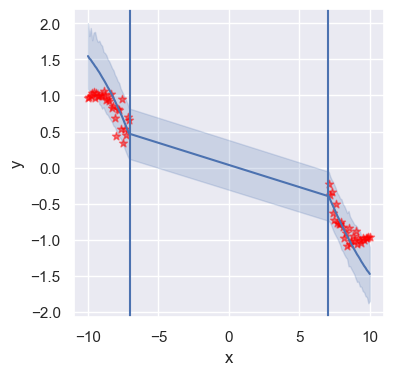

Epoch 149 | batch train loss: -0.8158494830131531 | test loss: 0.0586254708468914
Epoch 149 |batch train mse:0.07748133689165115| test mse:0.047224211506545544


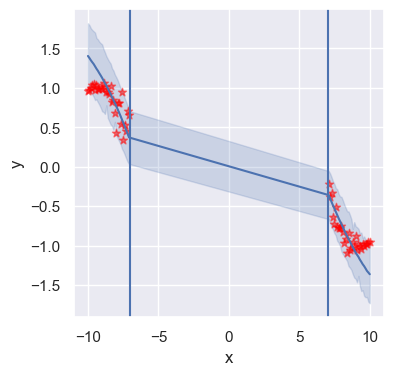

Epoch 149 | batch train loss: -1.073032021522522 | test loss: 0.30364659801125526
Epoch 149 |batch train mse:0.07613123208284378| test mse:0.05212463438510895


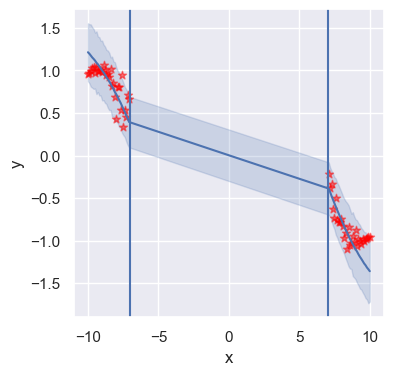

Epoch 149 | batch train loss: -1.3257651329040527 | test loss: -0.9625701159238815
Epoch 149 |batch train mse:0.04382968321442604| test mse:0.026800299296155572


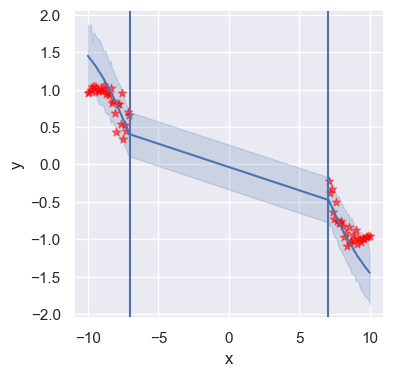

Epoch 149 | batch train loss: -1.0502678155899048 | test loss: 0.004112280905246735
Epoch 149 |batch train mse:0.10338658839464188| test mse:0.046133948024362326


In [19]:
train_losses_oodd=[]
test_losses_oodd=[]
errors_train_oodd=[]
errors_test_oodd=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = MLE_dopnn_oodd()
  train_losses_oodd.append(tr_loss)
  test_losses_oodd.append(test_loss)
  errors_train_oodd.append(mse_tr)
  errors_test_oodd.append(mse_test)

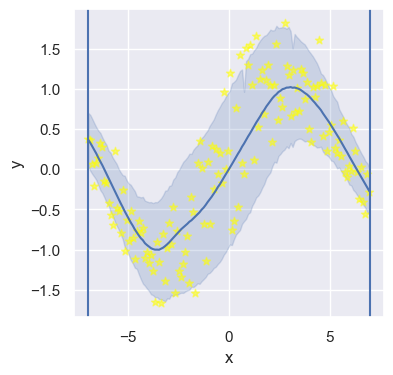

Epoch 149 | batch train loss: -0.8303704261779785 | test loss: 0.45949017918772167
Epoch 149 |batch train mse:0.08056801557540894| test mse:0.19228333648708132


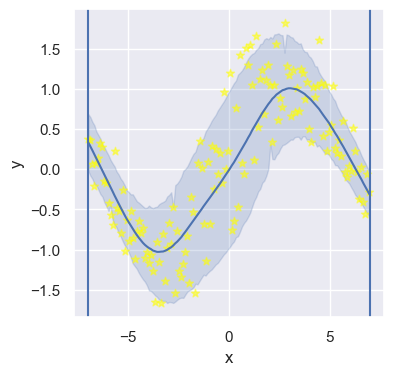

Epoch 149 | batch train loss: -1.4146580696105957 | test loss: 0.22249437040752834
Epoch 149 |batch train mse:0.05672343075275421| test mse:0.18288051833709082


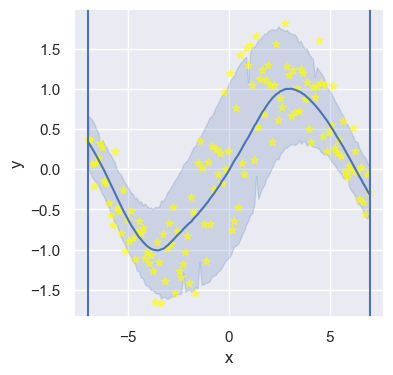

Epoch 149 | batch train loss: -1.3477768898010254 | test loss: 0.7032425552606583
Epoch 149 |batch train mse:0.023265453055500984| test mse:0.1910883995393912


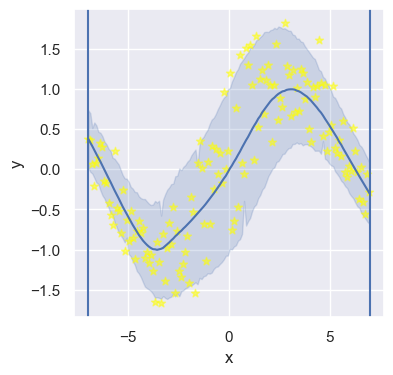

Epoch 149 | batch train loss: -1.0776927471160889 | test loss: 0.7942140657040808
Epoch 149 |batch train mse:0.056756094098091125| test mse:0.198578626745277


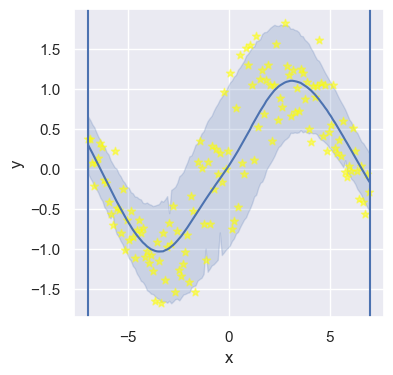

Epoch 149 | batch train loss: -1.365671992301941 | test loss: 0.7626790934138827
Epoch 149 |batch train mse:0.02666402794420719| test mse:0.1979710360368093


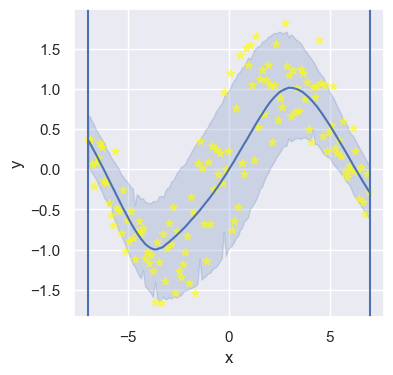

Epoch 149 | batch train loss: -1.3829046487808228 | test loss: 0.4143702983856201
Epoch 149 |batch train mse:0.035027313977479935| test mse:0.18699585066901314


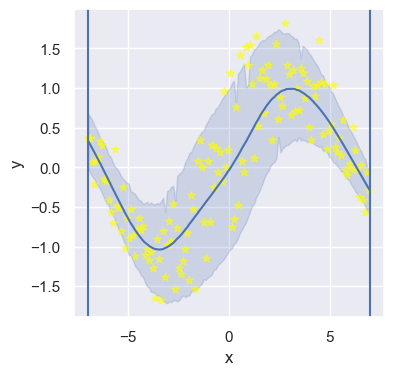

Epoch 149 | batch train loss: -1.5788383483886719 | test loss: 0.5677597721417745
Epoch 149 |batch train mse:0.022473549470305443| test mse:0.18762221270137364


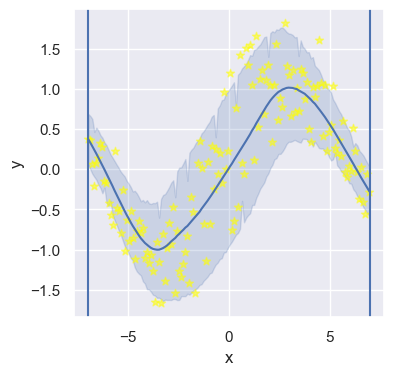

Epoch 149 | batch train loss: -1.0463546514511108 | test loss: 0.5222136146492429
Epoch 149 |batch train mse:0.05657491087913513| test mse:0.1910917427804735


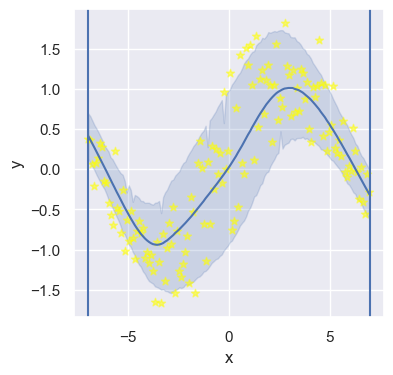

Epoch 149 | batch train loss: -1.3287488222122192 | test loss: 0.599586712817351
Epoch 149 |batch train mse:0.07744058966636658| test mse:0.19445333381493887


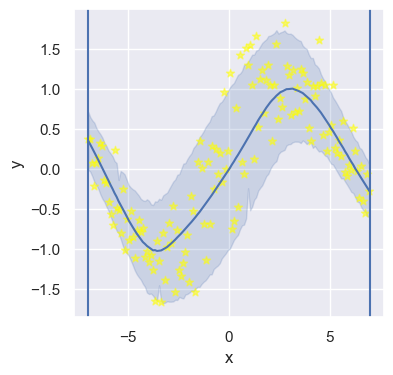

Epoch 149 | batch train loss: -0.9616147875785828 | test loss: 0.5491223533948263
Epoch 149 |batch train mse:0.05243762210011482| test mse:0.19404533257087073


In [20]:
train_losses_idd=[]
test_losses_idd=[]
errors_train_idd=[]
errors_test_idd=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = MLE_dopnn_idd()
  train_losses_idd.append(tr_loss)
  test_losses_idd.append(test_loss)
  errors_train_idd.append(mse_tr)
  errors_test_idd.append(mse_test)

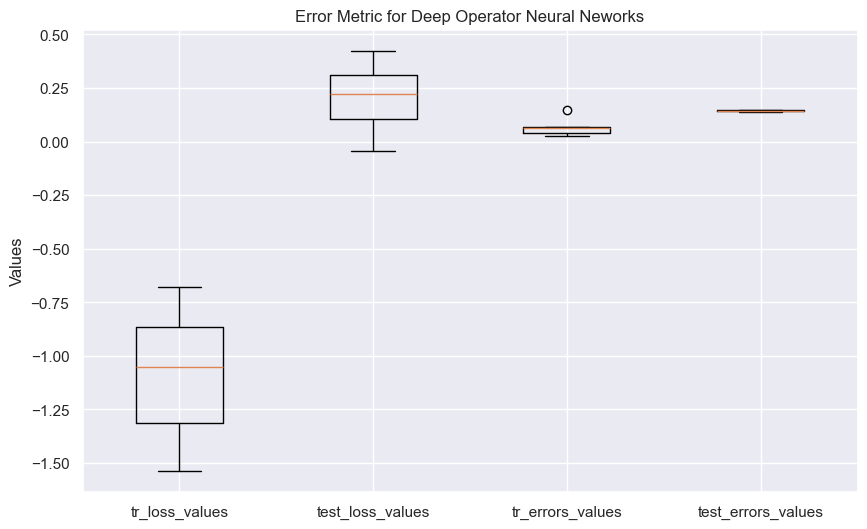

In [21]:
# Extract numerical values from the tensors and remove grad_fn
tr_loss_values= [tensor.item() for tensor in train_losses]
test_loss_values=test_losses
tr_errors_values= [tensor.item() for tensor in errors_train]
test_errors_values= errors_test

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create box plots for each dataset
box_plot_data = [tr_loss_values, test_loss_values, tr_errors_values, test_errors_values]
box_labels = ['tr_loss_values', 'test_loss_values', 'tr_errors_values', 'test_errors_values']

ax.boxplot(box_plot_data, labels=box_labels)

# Add labels and title

ax.set_ylabel('Values')
ax.set_title('Error Metric for Deep Operator Neural Neworks')

# Show the plot
plt.show()


In [22]:

mean_gaus_train_loss = np.mean(tr_loss_values)
std_dev_gaus_train_loss = np.std(tr_loss_values)

mean_gaus_test_loss = np.mean(test_loss_values)
std_dev_gaus_test_loss = np.std(test_loss_values)

mean_mse_train = np.mean(tr_errors_values)
std_dev_mse_train = np.std(tr_errors_values)

mean_mse_test = np.mean(test_errors_values)
std_dev_mse_test = np.std(test_errors_values)

print('Mean of Gausiann Training Loss of 10 runs ', mean_gaus_train_loss)
print('Standard Deviation of Gausiann Training Loss of 10 runs ' , std_dev_gaus_train_loss )

print('Mean of Gausiann Testing Loss of 10 runs ',mean_gaus_test_loss )
print('Standard Deviation of Gausiann Testing Loss of 10 runs ',std_dev_gaus_test_loss)

print('Mean of MSE Training of 10 runs ',mean_mse_train)
print('Standard Deviation of MSE Training of 10 runs ' , std_dev_mse_train)

print('Mean of MSE Testing of 10 runs ',mean_mse_test )
print('Standard Deviation of MSE Testing of 10 runs ', std_dev_mse_test)

Mean of Gausiann Training Loss of 10 runs  -1.0838060915470122
Standard Deviation of Gausiann Training Loss of 10 runs  0.26144969600774426
Mean of Gausiann Testing Loss of 10 runs  0.20587354139066663
Standard Deviation of Gausiann Testing Loss of 10 runs  0.13852426540678608
Mean of MSE Training of 10 runs  0.061582644097507
Standard Deviation of MSE Training of 10 runs  0.03191041967827281
Mean of MSE Testing of 10 runs  0.14393136091530326
Standard Deviation of MSE Testing of 10 runs  0.00397001173532096


In [23]:
# Create a DataFrame from the lists
data = {
    'Training Loss': tr_loss_values,
    'Testing Loss': test_loss_values,
    'Mean Squared Training Error': tr_errors_values,
    'Mean Squared Testing Error': test_errors_values
}

num_columns = len(data)

column_names = ['Training Loss','Testing Loss', 'Mean Squared Training Error','Mean Squared Testing Error']

# Create a DataFrame with dynamic column names
df = pd.DataFrame(data, columns=column_names)
df.index += 1
# Display the DataFrame as a table
print(df)
df.to_csv('results_donn.csv', index=True)

    Training Loss  Testing Loss  Mean Squared Training Error  \
1       -0.835043      0.282048                     0.065910   
2       -1.346346     -0.042508                     0.067546   
3       -0.677233      0.098768                     0.145287   
4       -1.123211      0.198556                     0.068324   
5       -1.208981      0.352648                     0.027374   
6       -1.357194      0.322435                     0.038161   
7       -0.979572      0.119287                     0.058825   
8       -0.927330      0.060217                     0.045839   
9       -0.847406      0.424131                     0.069276   
10      -1.535747      0.243153                     0.029285   

    Mean Squared Testing Error  
1                     0.141876  
2                     0.135924  
3                     0.138522  
4                     0.149448  
5                     0.146474  
6                     0.145452  
7                     0.144272  
8                     0.147311 

In [24]:
print(test_errors_values)

[0.14187627400343233, 0.13592416134018165, 0.1385218879351249, 0.14944797811599878, 0.14647420667684996, 0.1454516494503388, 0.14427228558522004, 0.14731106964441446, 0.1468747894351299, 0.14315930696634147]
